<a href="https://colab.research.google.com/github/luciadeangulo/UFV-Visualizacion/blob/main/ejercicios_clase/clase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EJERCICIO HISTÓRICO DE VENTAS: PLANIFICACIÓN


In [3]:
import matplotlib.pyplot as plt

In [4]:
import pandas as pd
df = pd.read_csv('datos_ejercicio_ventas.csv')
print(df.head())

         COUNTRY        SUBBRAND  YEAR  MONTH     SCENARIO FORECAST  \
0       Portugal     Lipton (L3)  2023     12  AI_forecast  AI_P02F   
1  Great Britain     Lipton (L3)  2023     12  AI_forecast  AI_P10F   
2          Spain  Pepsi Max (L3)  2023     12  AI_forecast  AI_P09F   
3  Great Britain        7up (L3)  2024     12  AI_forecast  AI_P10F   
4        Hungary     Lipton (L3)  2023      9  AI_forecast  AI_P03F   

   FORECAST_YEAR         AMOUNT  
0         2023.0  754356.237194  
1         2023.0  560030.558029  
2         2023.0   88501.980847  
3         2023.0  363224.511516  
4         2023.0  396176.120491  


**amount** : volumen ventas en litros

**subbrand** : producto que se ha vendido (lipton ej)

**scenario** : Ai_forecast(se ha predicho) o actual(venta real)

**month** : en caso de forecast, esto indica para cuándo se hace la predicción

**forecast** : mes cuando se hizo la predicción.  numero-1 = mes (2-12). pero diciembre es solo PF.

**forecast_year** : año cuando se hizo la predicción

In [5]:
print(df.describe())
print(df.info())

               YEAR         MONTH  FORECAST_YEAR        AMOUNT
count  18666.000000  18666.000000        17766.0  1.866600e+04
mean    2023.716383      6.475463         2023.0  9.721822e+05
std        0.590782      3.463632            0.0  1.915283e+06
min     2023.000000      1.000000         2023.0 -2.171201e+05
25%     2023.000000      3.000000         2023.0  8.754541e+04
50%     2024.000000      6.000000         2023.0  3.081759e+05
75%     2024.000000      9.000000         2023.0  1.078576e+06
max     2025.000000     12.000000         2023.0  1.481563e+07
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18666 entries, 0 to 18665
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   COUNTRY        18666 non-null  object 
 1   SUBBRAND       18666 non-null  object 
 2   YEAR           18666 non-null  int64  
 3   MONTH          18666 non-null  int64  
 4   SCENARIO       18666 non-null  object 
 5   FORECAST    

No hay valores null.  Hay 18666 registros por columna, excepto las variables relacionadas con las previsiones, lo cual tiene sentido porque hay registros que son reales y no predichos.

Parece que hay al menos un valor negativo en la variable Amount, lo cual no tiene sentido.

In [6]:
amount_negativos = df[df['AMOUNT']<0]
amount_negativos.shape

(10, 8)

De casi 19000 registros, tan solo hay 10 registros con las ventas negativas.  Se eliminarán, ya que es una cantidad despreciable de datos.

In [7]:
df = df[df['AMOUNT']>=0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18656 entries, 0 to 18665
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   COUNTRY        18656 non-null  object 
 1   SUBBRAND       18656 non-null  object 
 2   YEAR           18656 non-null  int64  
 3   MONTH          18656 non-null  int64  
 4   SCENARIO       18656 non-null  object 
 5   FORECAST       17766 non-null  object 
 6   FORECAST_YEAR  17766 non-null  float64
 7   AMOUNT         18656 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 1.3+ MB


Se revisará si hay datos duplicados.

In [8]:
duplicados = df[df.duplicated()]
duplicados

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT
349,Great Britain,Lipton (L3),2024,9,AI_forecast,AI_P11F,2023.0,7.367201e+05
455,Great Britain,Lipton (L3),2024,6,AI_forecast,AI_P03F,2023.0,8.156165e+05
540,Great Britain,7up Free (L3),2024,2,AI_forecast,AI_PF,2023.0,9.402300e+05
652,Great Britain,Lipton (L3),2024,1,AI_forecast,AI_P05F,2023.0,5.730475e+05
789,Great Britain,Lipton (L3),2024,11,AI_forecast,AI_P11F,2023.0,7.039466e+05
...,...,...,...,...,...,...,...,...
18590,Hungary,7up (L3),2025,1,AI_forecast,AI_P12F,2023.0,0.000000e+00
18606,Great Britain,7up Free (L3),2024,8,AI_forecast,AI_P03F,2023.0,1.117629e+06
18631,Great Britain,7up (L3),2024,10,AI_forecast,AI_P11F,2023.0,7.512755e+04
18649,Great Britain,Lipton (L3),2024,5,AI_forecast,AI_P11F,2023.0,9.124481e+05


Hay 663 registros duplicados.  No aportan información, más bien pueden perturbar los datos.  Por ejemplo, si hay muchos duplicados de España, el número de ventas que se cuenta no es el real.  Se eliminan.

In [9]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17993 entries, 0 to 18665
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   COUNTRY        17993 non-null  object 
 1   SUBBRAND       17993 non-null  object 
 2   YEAR           17993 non-null  int64  
 3   MONTH          17993 non-null  int64  
 4   SCENARIO       17993 non-null  object 
 5   FORECAST       17103 non-null  object 
 6   FORECAST_YEAR  17103 non-null  float64
 7   AMOUNT         17993 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 1.2+ MB


Ahora se analizará si hay outliers en nuestra base de datos.  

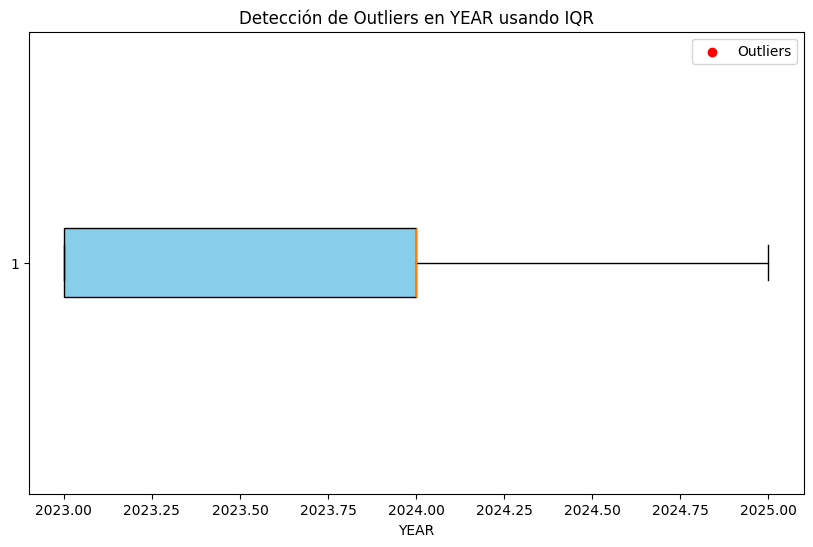

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT


In [10]:
# Seleccionar la columna de interés (por ejemplo, 'AMOUNT')
Q1 = df['YEAR'].quantile(0.25)
Q3 = df['YEAR'].quantile(0.75)
IQR = Q3 - Q1

# Identificar los outliers
outliers = df[(df['YEAR'] < (Q1 - 1.5 * IQR)) |
                            (df['YEAR'] > (Q3 + 1.5 * IQR))]

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Boxplot de 'AMOUNT'
plt.boxplot(df['YEAR'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))

# Añadir puntos para los outliers
plt.scatter(outliers['YEAR'], [1] * len(outliers), color='red', label='Outliers')

# Añadir etiquetas y leyenda
plt.title('Detección de Outliers en YEAR usando IQR')
plt.xlabel('YEAR')
plt.legend()
plt.show()

outliers

PREGUNTAS PREVIAS PARA ENTENDER LOS DATOS:

1. Número actuals y forecasts

2. Horizonte de predicción (si hago previsión para enero y febrero, ej, el horizonte de predicción es 2, con frecuencia mensual): tiempo hacia el futuro para el cual se hacen previsiones.

3. Nº países y de productos

4. Histórico de actuals y forecasts

5. Forecasts distintos.

In [11]:
!pip install plotly_express
import plotly.express as px

1. Números Actuals y Forecasts

In [12]:
scenarios = df['SCENARIO'].value_counts()
scenarios

,count
SCENARIO,
AI_forecast,17103
actual,890


2. Horizonte de predicción

In [13]:
#solo tengo en cuenta los registros que son predicciones
predicciones = df[df['SCENARIO'] == 'AI_forecast']
#último año + mes de las predicciones totales
#uso variable year porque quiero el año para el cual predigo, no en el que predigo
max_year = predicciones['YEAR'].max()
max_month = predicciones[predicciones['YEAR'] == max_year]['MONTH'].max()
max_year, max_month

(2025, 5)

Ya tengo el mes (mayo) y el año (2025) para cuando se ha hecho la última predicción.  Ahora necesito el último mes+año de 'actual' para ver cuál es el último dato 'real' de ventas.

In [14]:
actuals = df[df['SCENARIO'] == 'actual']
max_actual_year = actuals['YEAR'].max()
max_actual_month = actuals[actuals['YEAR'] == max_actual_year]['MONTH'].max()
max_actual_year,max_actual_month

(2024, 8)

Ahora calculo la diferencia entre ambos:

In [15]:
horizonte_years = max_year - max_actual_year
horizonte_months = max_month - max_actual_month

In [16]:
# Si los meses son negativos, ajustar los años
if horizonte_months < 0:
    horizonte_years -= 1
    horizonte_months += 12

In [17]:
horizonte_years,horizonte_months

(0, 9)

El horizonte de predicción es de 9 meses.

3.  Número de países y productos

In [18]:
paises = df['COUNTRY'].value_counts()
productos = df['SUBBRAND'].value_counts()
paises, productos

(COUNTRY
 Great Britain    3372
 Netherlands      2476
 Hungary          2358
 Denmark          2294
 Spain            2152
 Norway           2051
 Czech            1403
 Portugal         1179
 Italy             708
 Name: count, dtype: int64,
 SUBBRAND
 Pepsi Max (L3)        5538
 Pepsi Regular (L3)    3576
 Lipton (L3)           2484
 7up (L3)              2470
 7up Free (L3)         2283
 Mountain Dew (L3)     1642
 Name: count, dtype: int64)

Hay 9 países y 6 marcas de bebidas.

3.  Histórico Actuals y Forecasts de todo el conjunto de datos

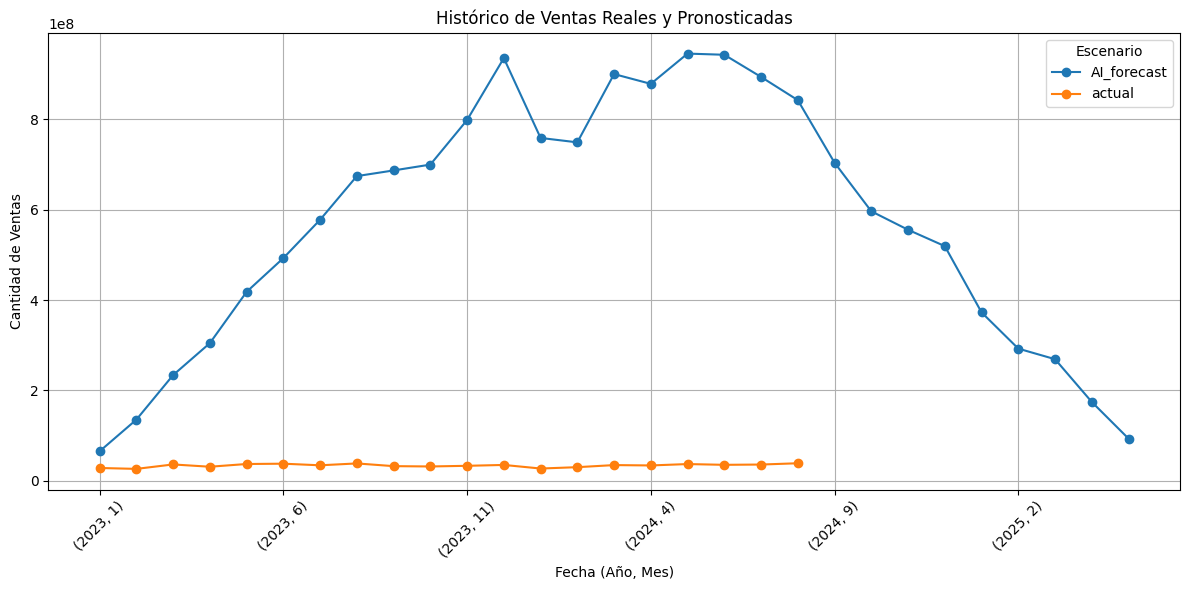

In [20]:
import matplotlib.pyplot as plt

# Group data by 'YEAR', 'MONTH', and 'SCENARIO' and calculate the sum of 'AMOUNT' for each group
historical_data = df.groupby(['YEAR', 'MONTH', 'SCENARIO'])['AMOUNT'].sum().unstack()

# Plot the data
plt.figure(figsize=(12, 6))
historical_data.plot(marker='o', ax=plt.gca())
plt.title('Histórico de Ventas Reales y Pronosticadas')
plt.xlabel('Fecha (Año, Mes)')
plt.ylabel('Cantidad de Ventas')
plt.legend(title='Escenario')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


5.  Los distintos forecasts

In [21]:
# Extract unique values from the 'FORECAST' column to identify distinct forecast types
distinct_forecasts = df['FORECAST'].unique()
ano_forecast = df['FORECAST_YEAR'].unique()

print(distinct_forecasts)
print(ano_forecast)

['AI_P02F' 'AI_P10F' 'AI_P09F' 'AI_P03F' 'AI_PF' 'AI_P11F' 'AI_P06F'
 'AI_P05F' 'AI_P07F' 'AI_P12F' 'AI_P08F' 'AI_P04F' nan]
[2023.   nan]


Se ve que hay forecasts para todos los meses del año.

**PREGUNTAS A RESPONDER**
1. Cómo se distribuyen las ventas realizadas en cada país, mes y año y marca.

2. Cuál es la tendencia y estacionalidad de todas las ventas del país con menos ventas y la marca con más ventas.

3.  Cuáles son las predicciones hechas en España y qué tan buenas son.

******************************************************************

1. Cómo se distribuyen las ventas realizadas en cada país: mes, año y marca.

<ipython-input-22-d0ac1496ede0>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="COUNTRY", y="AMOUNT", hue="SUBBRAND", ci=None)


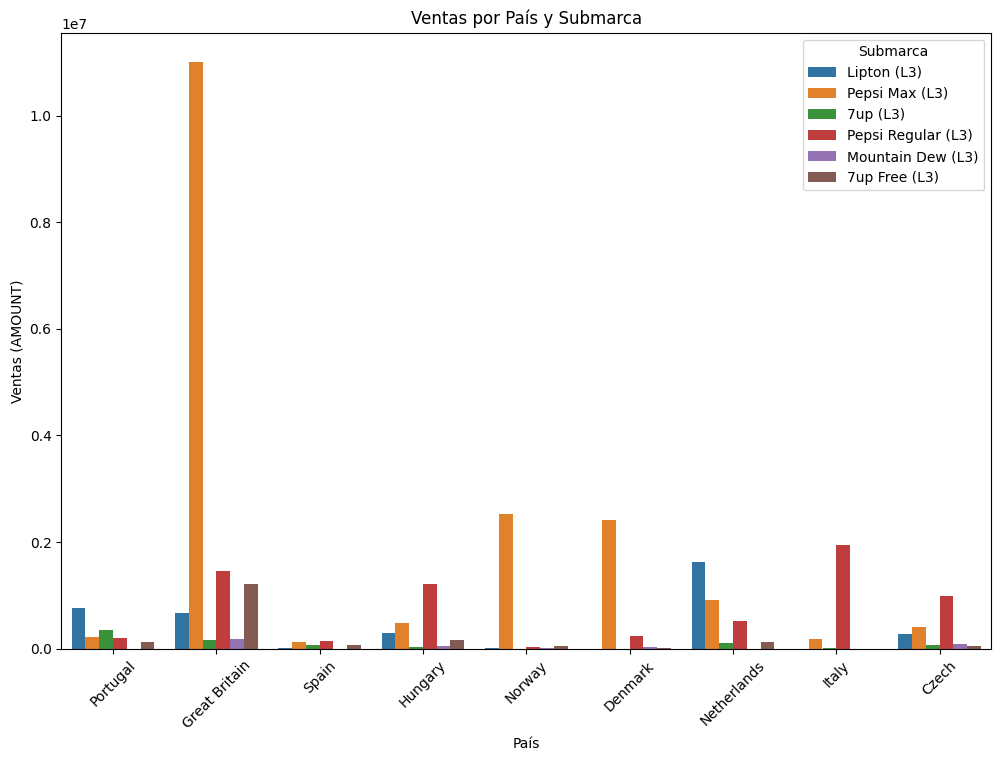

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 8))

# Crear el gráfico de barras
sns.barplot(data=df, x="COUNTRY", y="AMOUNT", hue="SUBBRAND", ci=None)

# Añadir título y etiquetas
plt.title("Ventas por País y Submarca")
plt.xlabel("País")
plt.ylabel("Ventas (AMOUNT)")

# Rotar las etiquetas del eje x si hay muchos países
plt.xticks(rotation=45)
plt.legend(title="Submarca")

# Mostrar el gráfico
plt.show()

Se ve claramente que en Reino Unido se consumen muchos más refrescos que en el resto de Europa.  España y Portugal consumen de manera equilibrada todas las bebidas, pero en una cantidad bastante más baja que en el resto de países.  Igualmente, se debe tener en cuenta que se están teniendo en cuenta las predicciones, asumiendo que son buenas, y no solo los actuals.

Se hará una gráfica por país para que se vea mejor.

<ipython-input-25-816e0468bf95>:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=country_data, x="SUBBRAND", y="AMOUNT", ci=None, palette="viridis")
<ipython-input-25-816e0468bf95>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=country_data, x="SUBBRAND", y="AMOUNT", ci=None, palette="viridis")
<ipython-input-25-816e0468bf95>:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=country_data, x="SUBBRAND", y="AMOUNT", ci=None, palette="viridis")
<ipython-input-25-816e0468bf95>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=country_data, x="SUBBRAN

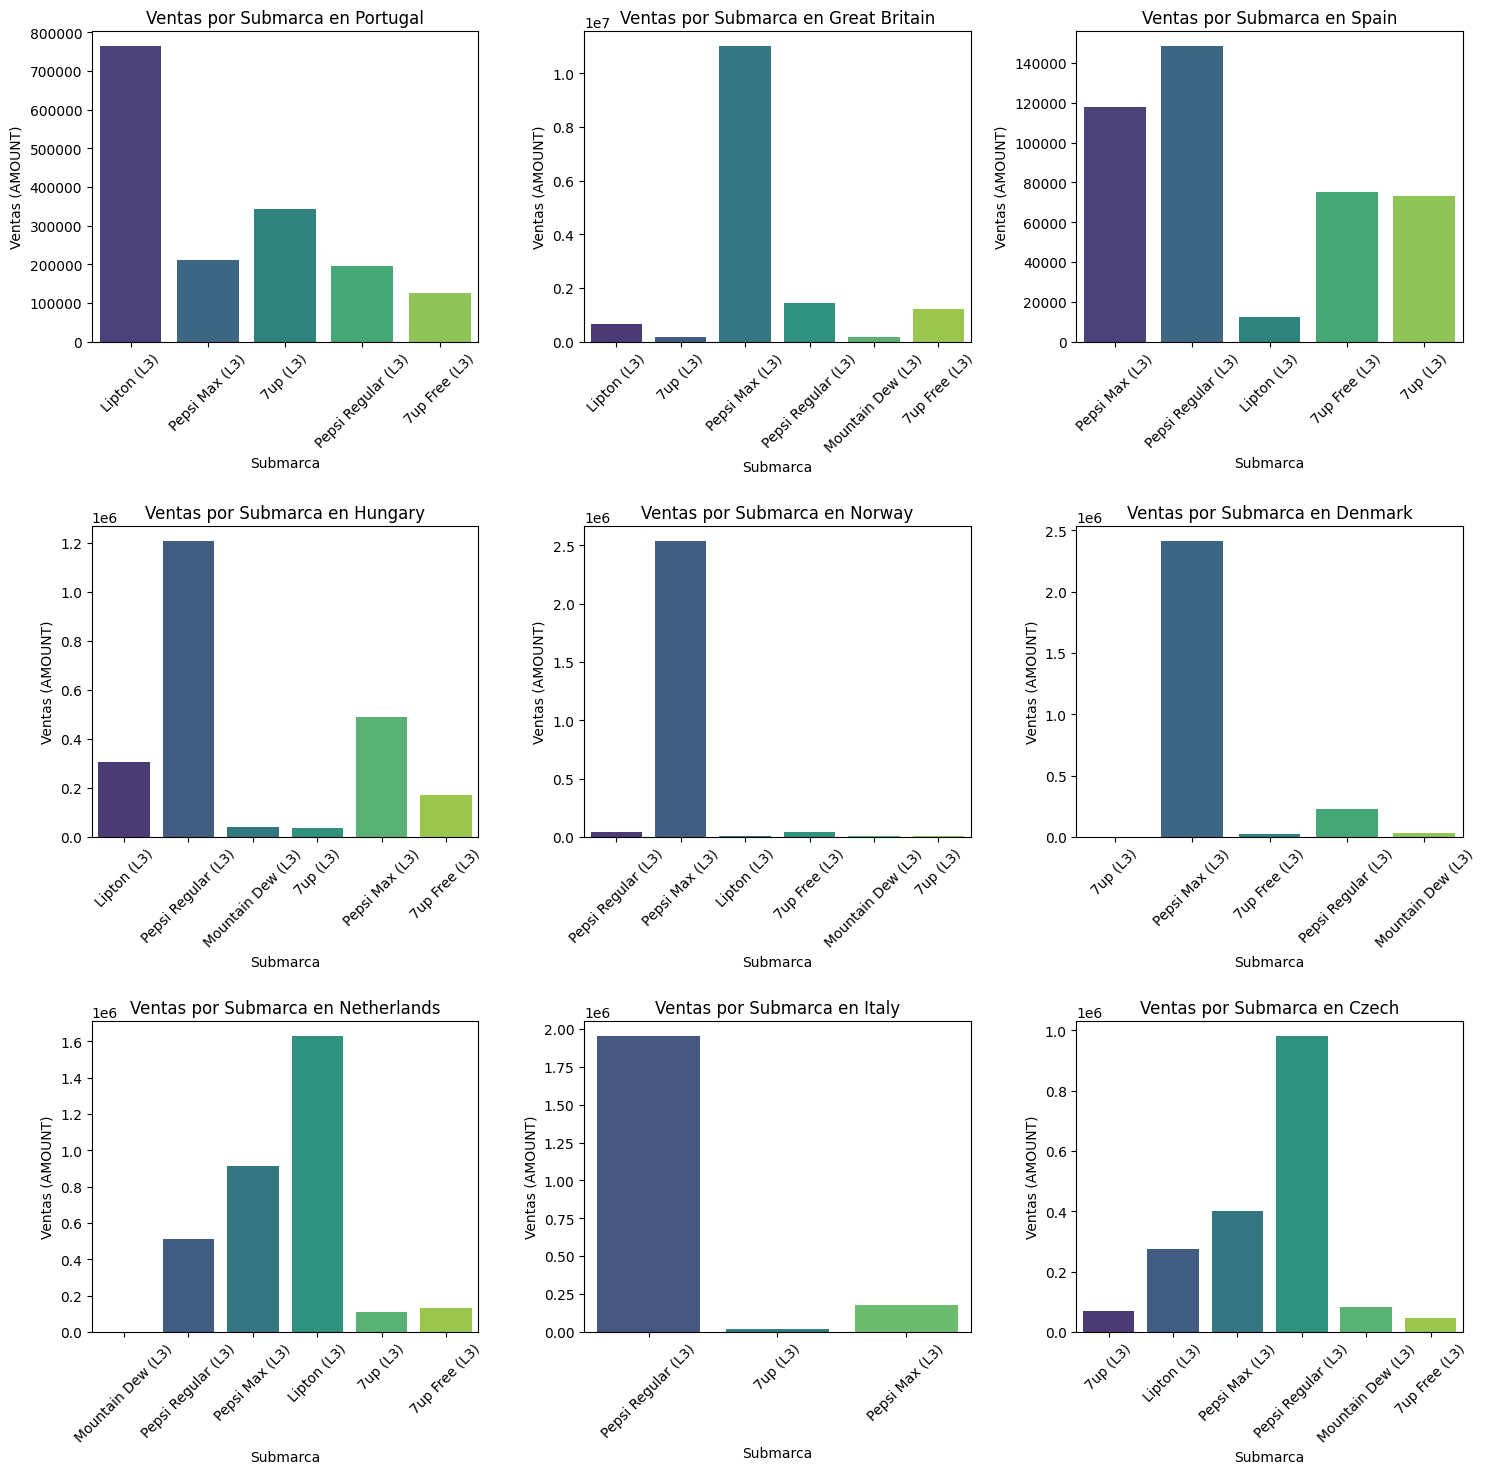

In [25]:
import math

# Obtener la lista de países únicos
countries = df['COUNTRY'].unique()
num_countries = len(countries)

# Determinar el tamaño de la cuadrícula de subplots
cols = 3  # Número de columnas en la cuadrícula
rows = math.ceil(num_countries / cols)  # Número de filas necesarias

# Configurar el tamaño de la figura
plt.figure(figsize=(15, rows * 5))

# Crear un subplot para cada país
for i, country in enumerate(countries):
    # Filtrar datos por país
    country_data = df[df['COUNTRY'] == country]

    # Crear subplot en la posición i+1
    plt.subplot(rows, cols, i + 1)

    # Crear el gráfico de barras para el país actual
    sns.barplot(data=country_data, x="SUBBRAND", y="AMOUNT", ci=None, palette="viridis")

    # Añadir título y ajustar etiquetas
    plt.title(f"Ventas por Submarca en {country}")
    plt.xlabel("Submarca")
    plt.ylabel("Ventas (AMOUNT)")
    plt.xticks(rotation=45)

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

DISTRIBUCIÓN BEBIDAS POR PAÍS:

En Portugal se consume más Lipton, aunque no hay una drástica diferencia con las demás bebidas.  En Reino Unido hay una gran preferencia por Pepsi Max, lo que sugiere que es muy popular en el mercado.

En España las ventas también están equilibradas (como en Portugal), pero la Pepsi, ya sea Max o Regular es la más consumida.  En Italia se vende mucho más la Pepsi Regular que el 7Up o la Pepsi Max.  Parece que en los países de la península ibérica y/o mediterráneos no está tan popularizado el consumo de bebidas azucaradas.

En Hungría, Noruega, Dinamarca y República Checa la Pepsi gana con diferencia a las demás bebidas.  Esto es un indicador de que en países más frios y lluviosos (también Reino Unido, como ya se ha visto) la Pepsi se consume bastante.  En cambio, en Países Bajos, la bebida más consumida es el Lipton, aunque no es drásticamente más popular que la Pepsi.

En ningún país parece ser que el 7Up o el Mountain Dew sean favoritos.  Mountain Dew aparece con ventas considerablemente bajas en todos los países.

En conclusión, Pepsi y Lipton son las marcas más compradas en los países europeos mencionados.  En el norte de Europa parece que domina la Pepsi Max (menos calorías), mientras que más hacia el sur de Europa, también hay una importance consumición de Pepsi Normal.

Ahora se analizarán las ventas de cada país por meses.

<Figure size 1500x1000 with 0 Axes>

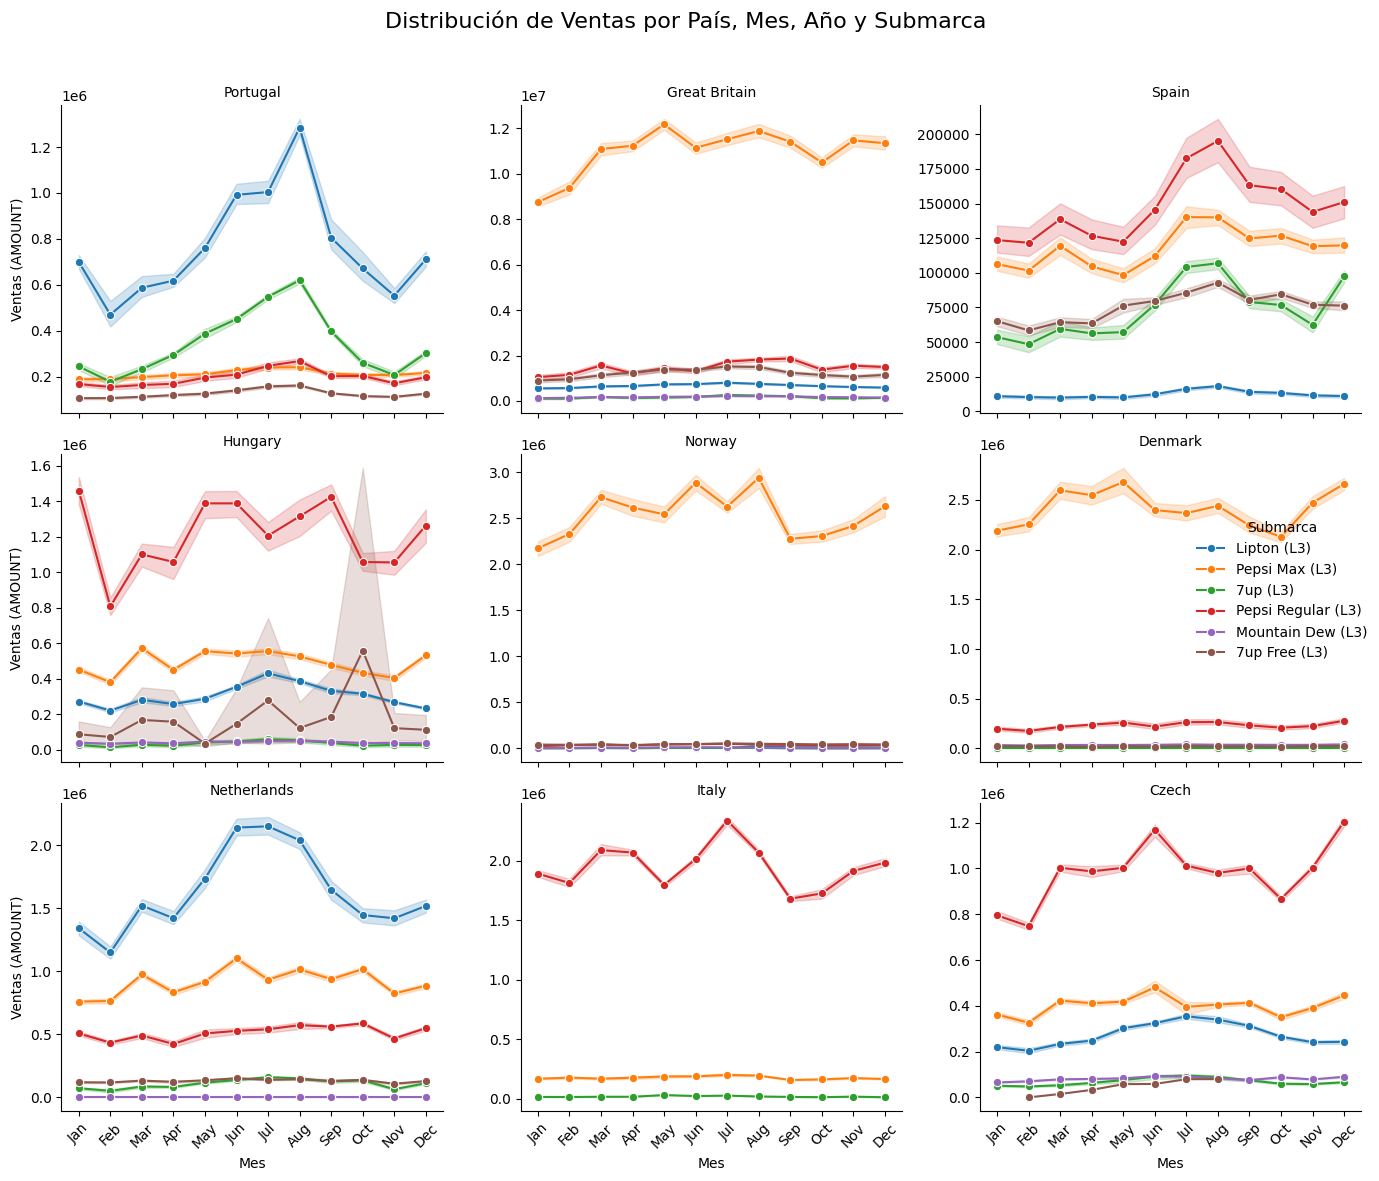

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración de gráficos para ajustar el tamaño
plt.figure(figsize=(15, 10))

# Crear un FacetGrid para mostrar la distribución de ventas por país, mes, año y sub-marca
g = sns.FacetGrid(df, col="COUNTRY", hue="SUBBRAND", col_wrap=3, height=4, sharey=False)
g.map(sns.lineplot, "MONTH", "AMOUNT", marker="o")

# Añadir leyenda y títulos
g.add_legend(title="Submarca")
g.set_axis_labels("Mes", "Ventas (AMOUNT)")
g.set_titles("{col_name}")

# Configurar los ticks del eje X para que muestren los meses de 1 a 12
for ax in g.axes.flat:
    ax.set_xticks(np.arange(1, 13, 1))  # Mostrar del 1 al 12 para representar los meses
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

# Título y ajuste de la visualización
plt.suptitle("Distribución de Ventas por País, Mes, Año y Submarca", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


En España, Portugal e Italia se ve una clara tendencia ascendente de las compras en los meses más calurosos como Julio y Agosto, lo cual es coherente, pues en estos países el clima es muy caluroso en dichos meses, por lo que la gente estará más dispuesta a comprar bebidas frías.

En Reino Unido hay cierta estacionalidad, no destaca ningún mes o período específico.  Las personas suelen comprar bebidas durante todo el año en la misma medida.

En Hungría, Noruega, Dinamarca y República Checa se sigue una tendencia similar: desde enero hasta mayo/junio las ventas crecen considerablemente, hasta octubre vuelven a disminuir y desde ahí hasta diciembre vuelve la tendencia ascendente.  Son países con climas similares, por lo que es normal que la gente tienda a comprar bebidas al mismo tiempo y en los mismos meses.  En Países Bajos hay una tendencia similar a la de estos países, pero no son cambios tan bruscos (no hay tantos picos), si no que la función de las compras es más suave.

2. Cuál es la tendencia y estacionalidad de todas las ventas del país con menos ventas y la marca con más ventas.

*NOTA: se tendrán en cuenta tanto los datos 'actual' como los predichos.*

Primero se identificarán el país con menos ventas y la marca con más.

In [30]:
# Cargar los datos
import pandas as pd

# Encontrar el pa\u00eds con menos ventas totales
ventas_por_pais = df.groupby('COUNTRY')['AMOUNT'].sum().sort_values()
pais_menos_ventas = ventas_por_pais.index[0]

# Encontrar la marca con m\u00e1s ventas totales
ventas_por_marca = df.groupby('SUBBRAND')['AMOUNT'].sum().sort_values(ascending=False)
marca_mas_ventas = ventas_por_marca.index[0]

print("El país con menos ventas es:", pais_menos_ventas)
print("La marca con más ventas es:", marca_mas_ventas)

El país con menos ventas es: Spain
La marca con más ventas es: Pepsi Max (L3)


Pepsi Max es el producto más vendido.  Pepsi es la marca más vendida contando los productos de Pepsi Max + Pepsi Regular.

Ahora se analizará la tendencia de la venta de Pepsi Max (elijo el producto más vendido en vez de la marca) en España y la estacionalidad cada mes.

TENDENCIA:

In [ ]:
# Analizar tendencia y estacionalidad para Espa\u00f1a (pa\u00eds con menos ventas) y Pepsi Max (marca con m\u00e1s ventas)
df['DATE'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str).str.zfill(2) + '-01')

# Datos para Espa\u00f1a
spain_data = df[df['COUNTRY'] == 'Spain'].copy()
spain_pepsi = spain_data[spain_data['SUBBRAND'] == 'Pepsi Max (L3)'].copy()

# Agrupar por fecha
spain_monthly = spain_pepsi.groupby('DATE')['AMOUNT'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(spain_monthly['DATE'], spain_monthly['AMOUNT'])
plt.title('Tendencia de ventas de Pepsi Max en Espa\u00f1a')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


En las fechas de julio y agosto sube considerablemente la venta de Pepsi Max, lo cual tiene sentido ya que son los meses con más calor en España.  El consumo general de la Pepsi Max ha sufrido leves bajadas pero su tendencia es ascendente hasta julio de 2024, el mes con má ventas.  Desde ese momento la función tiene tendencia negativa, pues comienzan los meses más frios, por lo cual tiene sentido que se vendan menos refrescos.

En 2024 las ventas parecen haber subido un 50% con respecto al 2023.  Esto podría ser un indicador de que está haciendo un buen marketing y la gente lo elige ante otras marcas similares como la Coca Cola.

In [ ]:
# An\u00e1lisis de estacionalidad por mes
spain_seasonal = spain_pepsi.groupby('MONTH')['AMOUNT'].mean()

plt.figure(figsize=(10, 5))
plt.bar(spain_seasonal.index, spain_seasonal.values)
plt.title('Estacionalidad mensual de Pepsi Max en Espa\u00f1a')
plt.xlabel('Mes')
plt.ylabel('Ventas promedio')
plt.grid(True)
plt.tight_layout()
plt.show()

3. Predicciones hechas en España y qué tan buenas son.

Se calculará primero el error de las predicciones.

In [ ]:
# Filtrar las predicciones para España
df_spain = df[df['COUNTRY'] == 'Spain']

# Filtrar las filas que contienen predicciones
df_spain_predictions = df_spain[df_spain['SCENARIO'] == 'AI_forecast']

# Mostrar las predicciones
print(df_spain_predictions.head())

# Calcular la precisión si hay datos reales disponibles
df_spain_real = df_spain[df_spain['SCENARIO'] != 'AI_forecast']

# Si hay datos reales, comparar con las predicciones
if not df_spain_real.empty:
    # Agrupar por fecha para comparar
    real_vs_pred = df_spain_real.groupby('DATE')['AMOUNT'].sum().reset_index()
    pred_vs_real = df_spain_predictions.groupby('DATE')['AMOUNT'].sum().reset_index()
    comparison = pd.merge(real_vs_pred, pred_vs_real, on='DATE', suffixes=('_real', '_pred'))
    comparison['error'] = (comparison['AMOUNT_pred'] - comparison['AMOUNT_real']).abs()
    comparison['error_percentage'] = (comparison['error'] / comparison['AMOUNT_real']) * 100
    print(comparison.head())
else:
    print("No hay datos reales disponibles para comparar con las predicciones.")

In [ ]:
# Visualizar las predicciones vs valores reales
import matplotlib.pyplot as plt
import seaborn as sns

# Crear gr\u00e1fico de l\u00edneas para comparar predicciones vs reales
plt.figure(figsize=(12, 6))
plt.plot(comparison['DATE'], comparison['AMOUNT_real'], label='Real', marker='o')
plt.plot(comparison['DATE'], comparison['AMOUNT_pred'], label='Predicci\u00f3n', marker='o')
plt.title('Ventas Reales vs Predicciones en España')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Hay una gran diferencia entre las predicciones y los valores reales.  Los valores actuals son muy estacionales, a diferencia de las predicciones, que tienen una tendencia alcista.

Las predicciones no son precisas en absoluto.

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(comparison['DATE'], comparison['error_percentage'], marker='o', color='red')
plt.title('Error Porcentual de las Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Error (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Ahora se calcula la media de error absoluto.

In [ ]:
abs_error = comparison['error_percentage'].mean()
print("MAE:", abs_error, "%")

Hay una desviación demasiado grande.  Las predicciones han fallado mucho.